In [46]:
import numpy as np

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from sklearn import linear_model

# import statsmodels.api as sm

pd.set_option("display.precision", 8)

In [2]:
# we assume risk free rate remains stable at 0.13
# R_f = 0.13
# we can no longer assume

In [3]:
# load data
industry_portfolio_df = pd.read_excel("Industry_Portfolios.xlsx")
market_portfolio_df = pd.read_excel("Market_Portfolio.xlsx")
risk_factors_df = pd.read_excel("Risk_Factors.xlsx")

c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
# use merge for join inner i guess
concated_df = industry_portfolio_df.merge(market_portfolio_df, on="Date", how="inner")
concated_df = concated_df.merge(risk_factors_df, on="Date", how="inner")

In [5]:
portfolio_cols = concated_df.columns[1:12]

In [6]:
excess_risk_df = pd.DataFrame()
for x in portfolio_cols:
    excess_risk_df[f"{x}_excess"] = concated_df[x] - concated_df["Rf"]
# excess_risk_df

In [7]:
excess_cols = excess_risk_df.columns

In [8]:
concated_df = pd.concat([concated_df, excess_risk_df], axis=1)

In [9]:
sharpe = excess_risk_df.mean().to_numpy() / np.sqrt(excess_risk_df.var().to_numpy())

In [10]:
# regression for market model
market_model_result = []
x = excess_risk_df["Market_excess"].to_numpy()
for portfolio in excess_cols:
    # print(portfolio)
    y = excess_risk_df[portfolio].to_numpy()
    market_model_result.append(np.polyfit(x, y, 1)[::-1])

In [11]:
market_model_result_intercept = []
market_model_result_slope = []
for x in market_model_result:
    market_model_result_intercept.append(x[0])
    market_model_result_slope.append(x[1])
market_model_result_intercept = np.array(market_model_result_intercept)
market_model_result_slope = np.array(market_model_result_slope)

In [12]:
treynor = excess_risk_df.mean().to_numpy() / market_model_result_slope

In [13]:
jensen_alpha = (
    excess_risk_df.mean().to_numpy()
    - excess_risk_df["Market_excess"].mean() * market_model_result_slope
)

In [14]:
downside_df = excess_risk_df.mask(excess_risk_df > 0, 0, inplace=False)
semivariance = (downside_df**2).mean()

In [15]:
sortino = excess_risk_df.mean().to_numpy() / np.sqrt(semivariance).to_numpy()
sortino

array([0.35080415, 0.11196656, 0.24125968, 0.27361162, 0.17062042,
       0.24493997, 0.29303152, 0.27029392, 0.29004357, 0.08735095,
       0.20247518])

In [16]:
# regression for three factor alpha
market_factor = concated_df["Rm-Rf"]
size_factor = concated_df["SMB"]
value_factor = concated_df["HML"]
x = pd.concat([market_factor, size_factor, value_factor], axis=1)

In [17]:
three_factor_alpha = []
for port in excess_risk_df.columns:
    regr = linear_model.LinearRegression()
    y = excess_risk_df[port]
    regr.fit(x, y)
    three_factor_alpha.append(regr.intercept_)
three_factor_alpha = np.array(three_factor_alpha)
three_factor_alpha

array([ 3.86704486e-01, -4.74341829e-01,  1.53284594e-01,  5.23006987e-01,
       -6.59794239e-02,  2.00724023e-01,  2.55941067e-01,  2.57472322e-01,
        4.74410582e-01, -4.04411529e-01, -2.22044605e-16])

In [18]:
result = pd.DataFrame([sharpe, sortino, treynor, jensen_alpha, three_factor_alpha]).T
result = pd.concat([pd.DataFrame(portfolio_cols), result], axis=1)
result.set_axis(
    ["industry", "sharpe", "sortino", "treynor", "jensen_alpha", "three_factor_alpha"],
    axis="columns",
    inplace=True,
)
result = result[0:10]
result

C:\Users\kilo\AppData\Local\Temp\ipykernel_18248\4130082633.py:3: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  result.set_axis(


,industry,sharpe,sortino,treynor,jensen_alpha,three_factor_alpha
0,NoDur,0.23109876,0.35080415,1.18637224,0.36971748,0.38670449
1,Durbl,0.07235564,0.11196656,0.36746260,-0.41790314,-0.47434183
2,Manuf,0.16661646,0.24125968,0.75825124,0.16049431,0.15328459
3,Enrgy,0.18170846,0.27361162,1.14333039,0.50448515,0.52300699
4,HiTec,0.11855247,0.17062042,0.56429472,-0.06402359,-0.06597942
5,Telcm,0.16906437,0.24493997,0.83636337,0.19434803,0.20072402
6,Shops,0.19175336,0.29303152,0.95125831,0.27409258,0.25594107
7,Hlth,0.17252946,0.27029392,0.97143469,0.23696807,0.25747232
8,Utils,0.21094773,0.29004357,1.45233366,0.44652340,0.47441058
9,Other,0.06469292,0.08735095,0.29978096,-0.38750777,-0.40441153


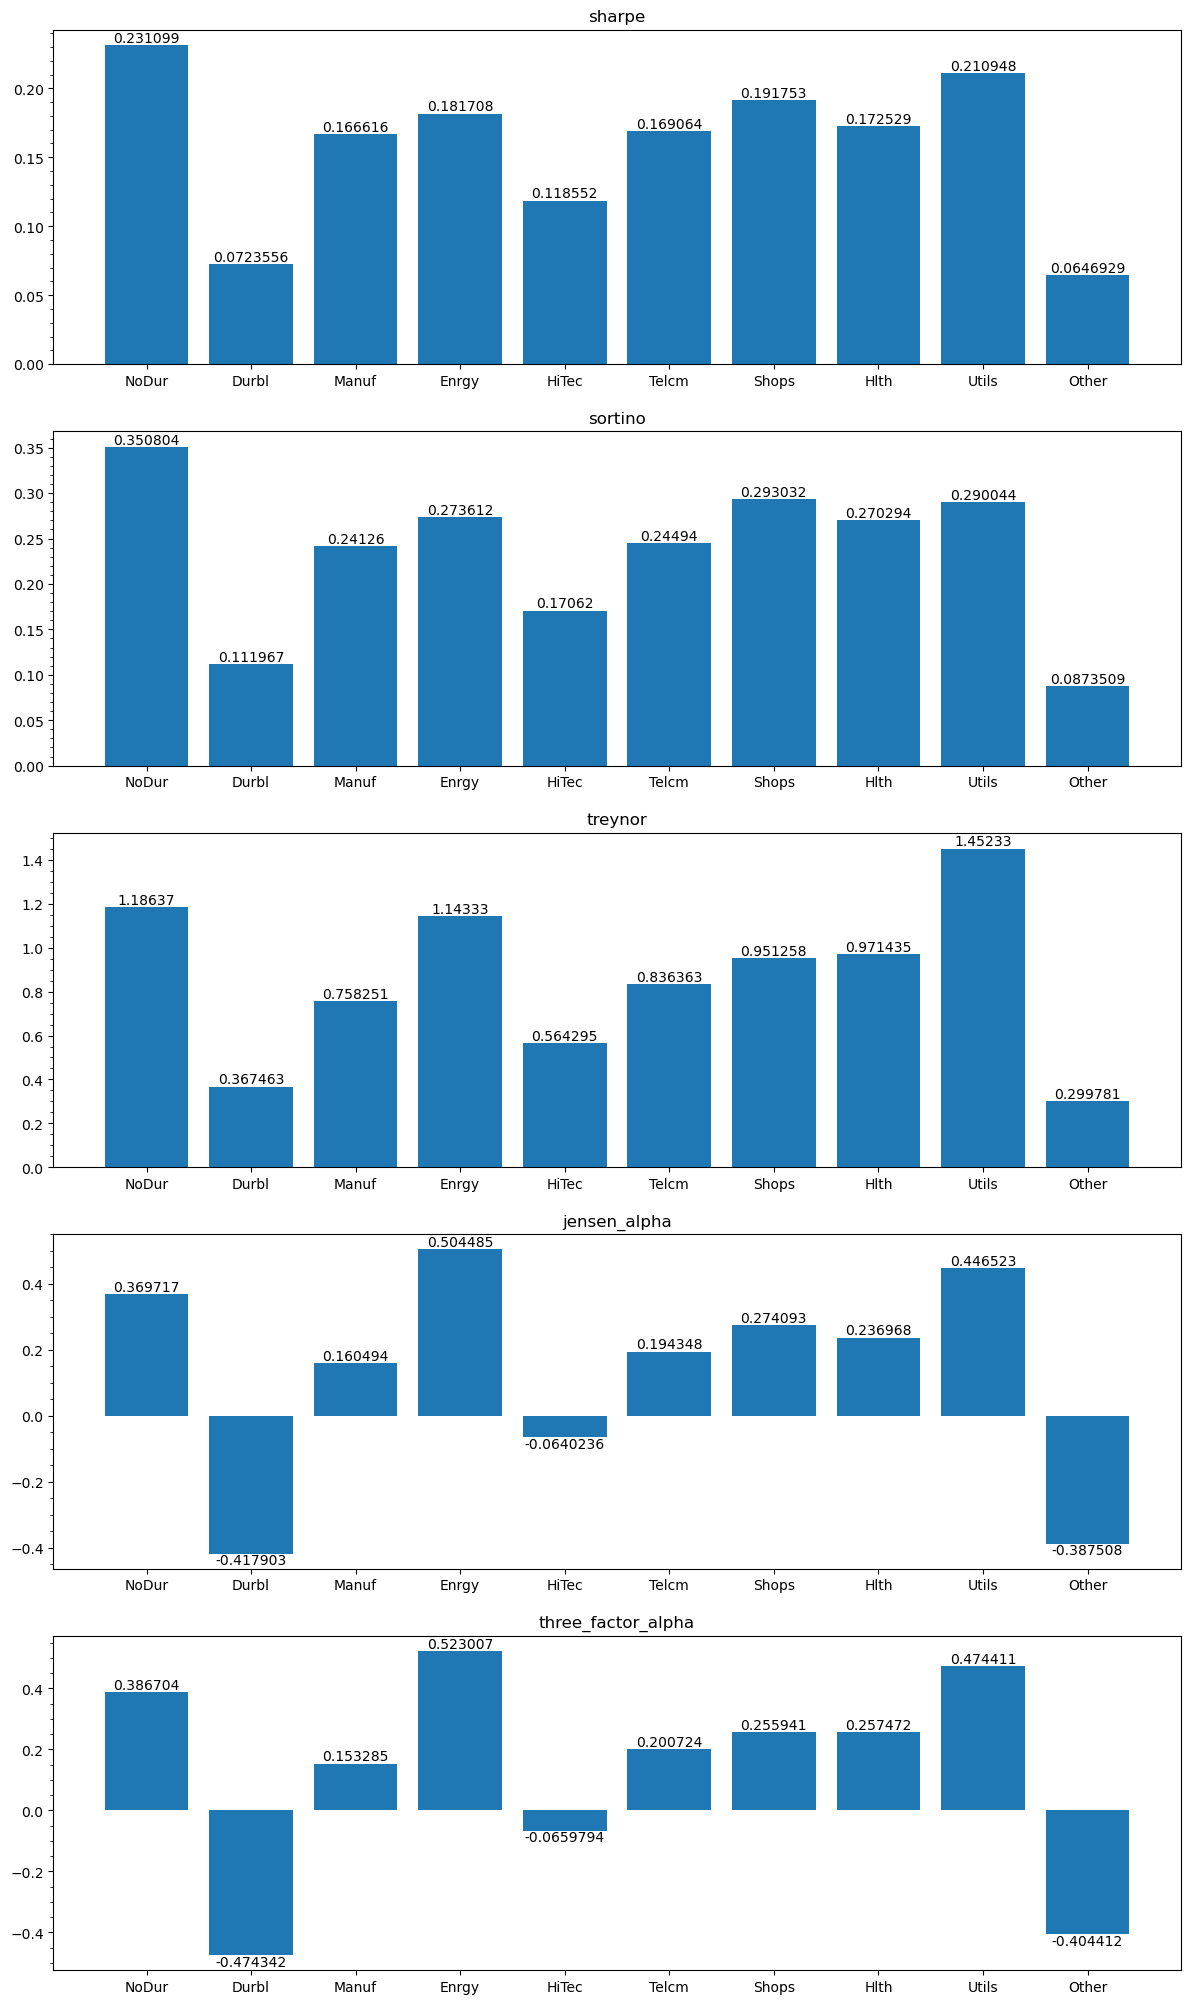

In [68]:
industries = result["industry"]
cols = result.columns
cols = cols[1:]
sharpe = result.iloc[:, 1]

fig, ax = plt.subplots(len(cols), 1, figsize=(10, 20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)
for i, x in enumerate(cols):
    bars = ax[i].bar(industries, result.iloc[:, 1 + i])
    ax[i].bar_label(bars)
    ax[i].set_title(x)
    ax[i].yaxis.set_major_locator(ticker.AutoLocator())
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
fig.savefig("risk_factors.jpeg")

In [ ]:
axs = result.plot.bar(
    figsize=(8, 15),
    subplots=True,
    sharex=False,
    title="Bar chart of each performance metric",
)
for ax in axs:
    ax.axhline(0, lw=0.5, color="black")
    ax.tick_params(axis="x", which="both", bottom=True, top=False)
    ax.set_xticklabels(result.industry, rotation=0)
    ax.get_legend().remove()
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(hspace=0.8)
plt.savefig("metrics.jpg")